# Goal: 
## Predict the outcome of a game based on what heroes have been picked 

In [32]:
%autoreload 2
import helper_functions as hlf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
df = pd.read_csv('dota_games.txt', sep=",", header=None, names=["Sentinal_1", "Sentinal_2", 
                                                                "Sentinal_3", "Sentinal_4", "Sentinal_5",
                                                                "Scourge_1", "Scourge_2", "Scourge_3", 
                                                                "Scourge_4", "Scourge_5", "Won"])
df.head()

,Sentinal_1,Sentinal_2,Sentinal_3,Sentinal_4,Sentinal_5,Scourge_1,Scourge_2,Scourge_3,Scourge_4,Scourge_5,Won
0,Sven,Lone Druid,Venomancer,Clockwerk,Shadow Shaman,Invoker,Gyrocopter,Anti-Mage,Alchemist,Slark,2
1,Riki,Tinker,Puck,Leshrac,Nyx Assassin,Slardar,Sand King,Spectre,Necrolyte,Warlock,1
2,Invoker,Mirana,Pudge,Magnus,Keeper of the Light,Rubick,Tidehunter,Queen of Pain,Faceless Void,Sniper,2
3,Riki,Centaur Warrunner,Treant Protector,Queen of Pain,Broodmother,Rubick,Weaver,Troll Warlord,Alchemist,Drow Ranger,1
4,Razor,Kunkka,Drow Ranger,Leshrac,Zeus,Riki,Bane,Visage,Invoker,Timbersaw,1


In [3]:
# check for fragmented data
df.isnull().sum()

Sentinal_1    0
Sentinal_2    0
Sentinal_3    0
Sentinal_4    0
Sentinal_5    0
Scourge_1     0
Scourge_2     0
Scourge_3     0
Scourge_4     0
Scourge_5     0
Won           0
dtype: int64

In [12]:
# create a new df with all the winning teams lineups
sentinal_df = df[['Sentinal_1','Sentinal_2','Sentinal_3','Sentinal_4','Sentinal_5','Won']]
sentinal_winners = sentinal_df[df.Won == 1]
sentinal_winners.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_df = df[['Scourge_1','Scourge_2','Scourge_3','Scourge_4','Scourge_5','Won']]
scourge_winners = scourge_df[df.Won == 2]
scourge_winners['Won'] = 1
scourge_winners.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# create a new df for the losing teams

sentinal_losers = sentinal_df[df.Won == 2]
sentinal_losers['Won'] = 0
sentinal_losers.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_losers = scourge_df[df.Won == 1]
scourge_losers['Won'] = 0
scourge_losers.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# merge the dataframes to create a df that contains all the lineups and if they won or not
lineups = pd.concat([sentinal_winners, scourge_winners, sentinal_losers, scourge_losers])
lineups.reset_index(drop=True, inplace=True)
# lines_csv = lineups.to_csv('lineups.csv', index = None, header=True)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Won
0,Riki,Tinker,Puck,Leshrac,Nyx Assassin,1
1,Riki,Centaur Warrunner,Treant Protector,Queen of Pain,Broodmother,1
2,Razor,Kunkka,Drow Ranger,Leshrac,Zeus,1
3,Morphling,Omniknight,Pudge,Crystal Maiden,Razor,1
4,Brewmaster,Leshrac,Ogre Magi,Kunkka,Riki,1
...,...,...,...,...,...,...
29995,Kunkka,Morphling,Tidehunter,Windrunner,Pudge,0
29996,Mirana,Lifestealer,Earthshaker,Invoker,Bounty Hunter,0
29997,Visage,Witch Doctor,Jakiro,Bloodseeker,Lycanthrope,0
29998,Outworld Devourer,Luna,Lion,Clockwerk,Tidehunter,0


In [5]:
# split the hero list from the outcome of the game
features_df = lineups.copy(deep=True)
labels = lineups[['Won']]
features_df.drop('Won', axis=1, inplace=True)

# use the populate function to create dummies columns for all the characters in the game
dummies_df = hlf.populate_df(features_df)
labeled_dummies_df = pd.concat([dummies_df, labels], axis=1)
# dummies_csv = labeled_dummies_df.to_csv ('dota2_characters.csv', index=False, header=True)

In [6]:
# Sort characters based on their main attribute (Strength, Agility, Intellegence)
str_heroes = hlf.main_attributes('Strength')
agi_heroes = hlf.main_attributes('Agility')
int_heroes = hlf.main_attributes('Intelligence')

# changing IO to WISP
for ind, hero in enumerate(str_heroes):
    if hero == 'Io':
        str_heroes[ind] = 'Wisp'

In [7]:
# create a new feature: how many strength heroes
str_df = features_df.where(~features_df.isin(str_heroes), None)
str_df = pd.DataFrame(str_df.isnull().sum(axis=1), columns=['Strength'])
# str_df.head()

In [8]:
# create a new feature: how many agility heroes
agi_df = features_df.where(~features_df.isin(agi_heroes), None)
agi_df = pd.DataFrame(agi_df.isnull().sum(axis=1), columns=['Agility'])
# agi_df.head()

In [9]:
# create a new feature: how many inteligence heroes
int_df = features_df.where(~features_df.isin(int_heroes), None)
int_df = pd.DataFrame(int_df.isnull().sum(axis=1), columns=['Intelligence'])
# int_df.head()

In [14]:
# roles = 'Ranged_heroes', 'Supports', 'Carries', 'Nukers', 'Disablers'

# create a new feature: how many ranged heroes in the team
ranged = hlf.hero_roles('Ranged_heroes')  
melee_df = features_df.where(~features_df.isin(ranged), None)
melee_df = pd.DataFrame(melee_df.isnull().sum(axis=1), columns=['Ranged'])
# melee_df.head()

# create new feature: amount of support characters in a team
support = hlf.hero_roles('Supports')
support_df = features_df.where(~features_df.isin(support), None)
support_df = pd.DataFrame(support_df.isnull().sum(axis=1), columns=['Support']) 
# support_df.head()

# create new feature: amount of carry character in a team
carry = hlf.hero_roles('Carries')
carry_df = features_df.where(~features_df.isin(carry), None)
carry_df = pd.DataFrame(carry_df.isnull().sum(axis=1), columns=['Carry']) 
# carry_df.head()

# create new feature: how many nukers in team
nukers = hlf.hero_roles('Nukers')
nukers_df = features_df.where(~features_df.isin(nukers), None)
nukers_df = pd.DataFrame(nukers_df.isnull().sum(axis=1), columns=['Nukers'])
# nukers_df.head()

# create new feature: how many disablers in team
disablers = hlf.hero_roles('Disablers')
disablers_df = features_df.where(~features_df.isin(disablers), None)
disablers_df = pd.DataFrame(disablers_df.isnull().sum(axis=1), columns=['Disablers'])
# disablers_df.head()

In [15]:
#offlane characters
offlane = np.array(['Abaddon', 'Axe', 'Batrider', 'Beasmaster',
                    'Brewmaster', 'Bristleback', 'Broodmother',
                    'Centaur Warrunner', 'Clockwerk', 'Dark Seer',
                    'Doom', 'Earthshaker', 'Enchantress', 'Enigma',
                    'Legion Commander', 'Magnus', "Nature's Prophet",
                    'Night Stalker', 'Nyx Assassin', 'Puck',
                    'Sand King', 'Slardar', 'Spirit Breaker', 
                    'Tidehunter', 'Undying', 'Underlord'])

# create new feature: amount of offlane characters in a team
offlane_df = features_df.where(~features_df.isin(offlane), None)
offlane_df = pd.DataFrame(offlane_df.isnull().sum(axis=1), columns=['Offlane'])
# offlane_df.head()

In [16]:
# middle lane characters
mid = np.array(['Alchemist', 'Arc Warden', 'Bloodseeker', 'Bristleback',
                'Broodmother', 'Death Prophet', 'Dragon Knight', 'Ember Spirit',
                'Faceless Void', 'Invoker', 'Wisp', 'Juggernaut',
                'Lina', 'Leshrac', 'Lone Druid', 'Magnus', 'Medusa', 'Meepo',
                'Mirana', "Nature's Prophet", 'Necrophos', 'Outworld Devourer',
                'Puck', 'Pugna', 'Queen of Pain', 'Razor', 'Shadow Fiend','Zeus' 
                'Skywrath Mage', 'Sniper', 'Storm Spirit', 'Templar Assassin',
                'Tinker', 'Tiny', 'Venomancer', 'Viper', 'Visage', 'Windrunner'])

# create new feature: how many mid lane appropriate characters
mid_df = features_df.where(~features_df.isin(mid), None)
mid_df = pd.DataFrame(mid_df.isnull().sum(axis=1), columns=['Mid'])
# mid_df.head()

In [17]:
# roaming support characters
roaming_support = np.array(['Bounty Hunter', 'Earth Spirit', 'Mirana', "Nature's Prophet",
                            'Pudge', 'Riki', 'Tusk', 'Techies', 'Spirit Breaker', 'Bane'
                            'Night Stalker', 'Windrunner', 'Lion', 'Earthshaker', 'Rubick'])

# create new feature: how many roaming characters
roam_df = features_df.where(~features_df.isin(roaming_support), None)
roam_df = pd.DataFrame(roam_df.isnull().sum(axis=1), columns=['Roamer'])
# roam_df.head()

In [ ]:
# see the list of most played hereos 
sum_picked = pd.DataFrame(dummies_df.sum(), columns=["Picked"])
sum_picked.sort_values(by=['Picked'], ascending=False, inplace=True)

sum_picked = sum_picked[['Picked']].apply(lambda x: x / 15000)
sum_picked.reset_index(inplace=True)
sum_picked.rename(columns={'index':'Hero'}, inplace=True)

# for graphing purposes get only the most picked characters
top12_picked = sum_picked.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_picked, x='Hero', y='Picked')
plt.title('Times Picked')
plt.ylabel('Picked (%)')
plt.xticks(rotation=45, ha='right')
plt.savefig('most_picked.png')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

<Figure size 864x576 with 0 Axes>

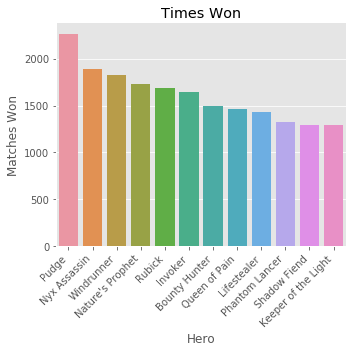

In [25]:
# see which hereos won the most games
winners_df = labeled_dummies_df.loc[labeled_dummies_df.Won == 1]
winners_df = winners_df.drop('Won', axis=1)
sum_wins = pd.DataFrame(winners_df.sum(), columns=["Wins"])

sort_sum_wins = sum_wins.sort_values(by=['Wins'], ascending=False)
sort_sum_wins = sort_sum_wins[['Wins']]
sort_sum_wins.reset_index(inplace=True)
sort_sum_wins.rename(columns={'index':'Hero'}, inplace=True)

# for graphing purposes plot the top 12
top12_wins = sort_sum_wins.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_wins, x='Hero', y='Wins')
plt.title('Times Won')
plt.ylabel('Matches Won')
plt.xticks(rotation=45, ha='right')
# plt.savefig('most_won.png')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

<Figure size 864x576 with 0 Axes>

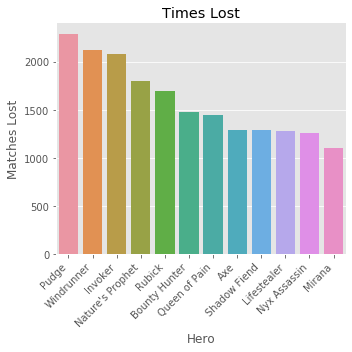

In [21]:
# see which heroes lost the most games
losers_df = labeled_dummies_df.loc[labeled_dummies_df.Won == 0]
losers_df = losers_df.drop('Won', axis=1)
sum_lose = pd.DataFrame(losers_df.sum(), columns=["Lose"])

sort_sum_lose = sum_lose.sort_values(by=['Lose'], ascending=False)

sort_sum_lose = sort_sum_lose[['Lose']]
sort_sum_lose.reset_index(inplace=True)
sort_sum_lose.rename(columns={'index':'Hero'}, inplace=True)

# for graphing purposes plot the top 12
top12_lose = sort_sum_lose.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_lose, x='Hero', y='Lose')
plt.title('Times Lost')
plt.ylabel('Matches Lost')
plt.xticks(rotation=45, ha='right')
# plt.savefig('most_lost.png')                 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

<Figure size 864x576 with 0 Axes>

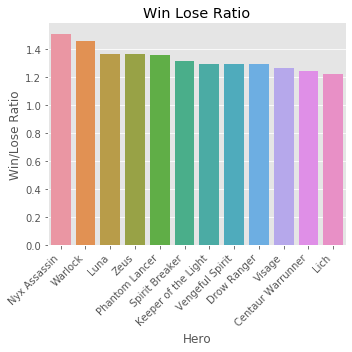

In [22]:
# plot the individual win rate of ever character
win_lose_df = pd.concat([sum_wins, sum_lose], axis=1).reset_index().rename(columns={'index':'Hero'})
win_lose_df['Ratio'] = win_lose_df['Win'] / win_lose_df['Lose']

# sort the characters by win/lose ratio
win_lose_df.sort_values(by=['Ratio'], ascending=False, inplace=True)
sort_ratio = win_lose_df[['Hero','Ratio']]

# extract the characters with highest/lowest win to lose ratio
top12_ratio = sort_ratio.head(12)
bot12_ratio = sort_ratio.tail(12)         

In [ ]:
# plot the highest win to lose ratio
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_ratio, x='Hero', y='Ratio')

# add labels
plt.title('Win Lose Ratio')
plt.ylabel('Win/Lose Ratio')
plt.xticks(rotation=45, ha='right')
# plt.savefig('win_lose_ratio.png')       

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

<Figure size 864x576 with 0 Axes>

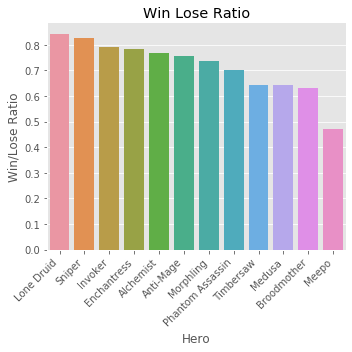

In [23]:
# plot the lowest win to lose ratio characters
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=bot12_ratio, x='Hero', y='Ratio')

# add labels
plt.title('Win Lose Ratio')
plt.ylabel('Win/Lose Ratio')
plt.xticks(rotation=45, ha='right')
# plt.savefig('win_lose_ratio_losers.png')            

In [24]:
# add features: highest and lowest win rates heroes  
top12_heroes = np.array(top12_ratio['Hero'])
bot12_heroes = np.array(bot12_ratio['Hero'])

# create new feature: heroes with highest win rate
high_rate_df = features_df.where(~features_df.isin(top12_heroes), None)
high_rate_df = pd.DataFrame(high_rate_df.isnull().sum(axis=1), columns=['High_Win'])

# create new feature: heroes with lowest win rate
low_rate_df = features_df.where(~features_df.isin(bot12_heroes), None)
low_rate_df = pd.DataFrame(low_rate_df.isnull().sum(axis=1), columns=['Low_Win'])

array(['Nyx Assassin', 'Warlock', 'Luna', 'Zeus', 'Phantom Lancer',
       'Spirit Breaker', 'Keeper of the Light', 'Vengeful Spirit',
       'Drow Ranger', 'Visage', 'Centaur Warrunner', 'Lich'], dtype=object)

In [26]:
# concatanate all the features together
cleaned_df = pd.concat([dummies_df, melee_df, str_df, agi_df, int_df, 
                         carry_df, support_df, offlane_df, mid_df, roam_df, nukers_df ,
                         disablers_df, high_rate_df, low_rate_df], axis=1)
                         
                         

# scaling features
cols = cleaned_df.columns
scaler = StandardScaler()
scaler.fit(cleaned_df)
scaled_features = scaler.transform(cleaned_df)

# combine the labels with the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=cols, index=cleaned_df.index)
scaled_features_df = pd.concat([scaled_features_df, labels.Won], axis=1)

# save as new csv to for modeling purpose
scaled_csv = scaled_features_df.to_csv('dota2_scaled.csv', index=None, header=True)
scaled_features_df()

Index(['Riki', 'Razor', 'Morphling', 'Brewmaster', 'Slardar', 'Wisp',
       'Omniknight', 'Slark', 'Ogre Magi', 'Chaos Knight',
       ...
       'Intelligence', 'Carry', 'Support', 'Offlane', 'Mid', 'Roamer',
       'Nukers', 'Disablers', 'High_Win', 'Low_Win'],
      dtype='object', length=110)


,Riki,Razor,Morphling,Brewmaster,Slardar,Wisp,Omniknight,Slark,Ogre Magi,Chaos Knight,...,Carry,Support,Offlane,Mid,Roamer,Nukers,Disablers,High_Win,Low_Win,Won
0,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.414513,-0.570063,1.007526,1.261730,0.157217,0.533190,0.532469,0.474901,-0.814275,1
1,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.414513,-0.570063,1.007526,0.266544,0.157217,-0.490404,-0.498516,0.474901,0.667752,1
2,-0.190351,6.441500,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,1.498774,0.549757,-1.304373,0.266544,-1.058379,0.533190,-0.498516,1.805530,-0.814275,1
3,-0.190351,6.441500,5.349299,-0.181034,-0.187513,-0.21094,5.444586,-0.245093,-0.197112,-0.211026,...,-0.669748,0.549757,-1.304373,-0.728642,0.157217,1.556785,-0.498516,-0.855727,0.667752,1
4,5.253443,-0.155243,-0.186940,5.523822,-0.187513,-0.21094,-0.183669,-0.245093,5.073260,-0.211026,...,1.498774,1.669576,-0.148424,-0.728642,0.157217,0.533190,1.563455,-0.855727,-0.814275,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.190351,-0.155243,5.349299,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.669748,-0.570063,-0.148424,-0.728642,1.372813,0.533190,0.532469,-0.855727,0.667752,0
29996,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.414513,0.549757,-0.148424,0.266544,2.588409,0.533190,0.532469,-0.855727,0.667752,0
29997,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-1.754009,1.669576,-1.304373,0.266544,-1.058379,0.533190,0.532469,0.474901,-0.814275,0
29998,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.669748,-0.570063,1.007526,-0.728642,0.157217,1.556785,0.532469,0.474901,-0.814275,0


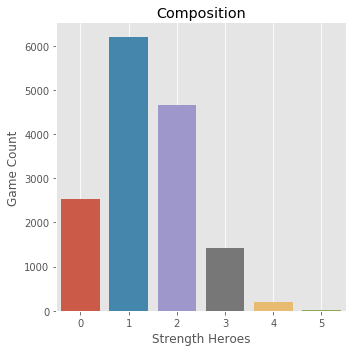

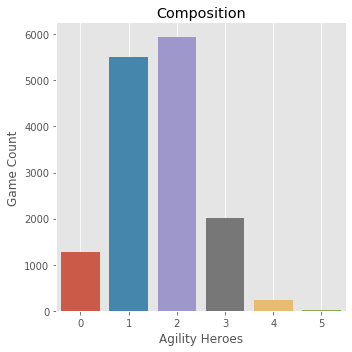

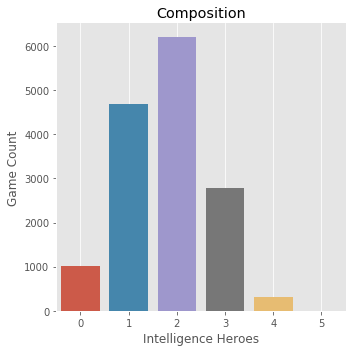

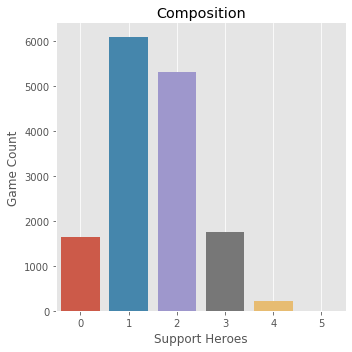

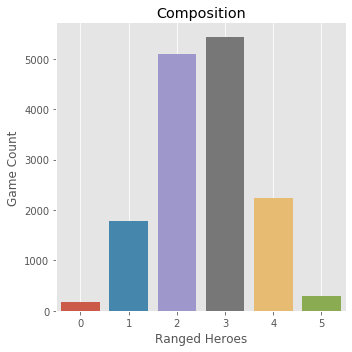

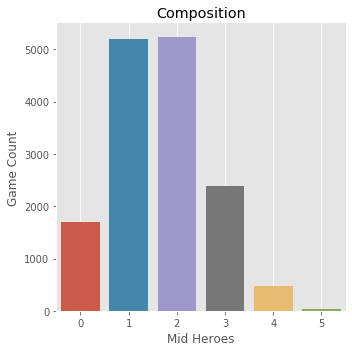

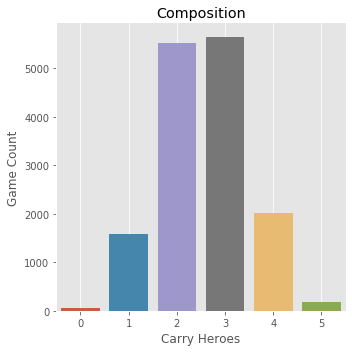

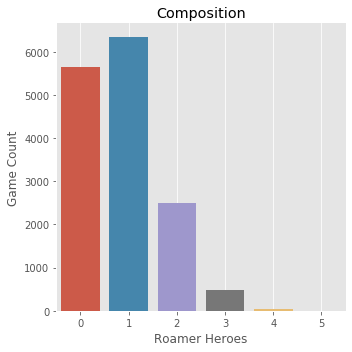

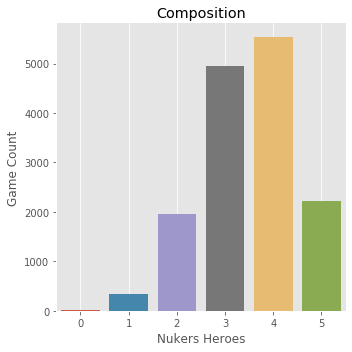

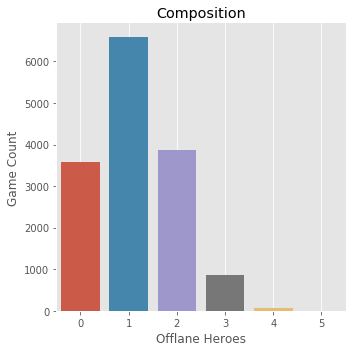

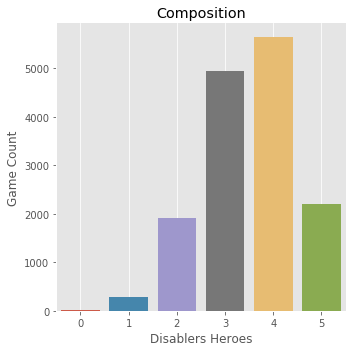

In [29]:
# check winning team compositions
winning_lineups = cleaned_df.loc[scaled_features_df.Won == 1]
attributes = ['Strength', 'Agility', 'Intelligence', 'Support', 'Ranged', 
              'Mid', 'Carry', 'Roamer', 'Nukers', 'Offlane', 'Disablers']

hlf.team_composition(winning_lineups, attributes)    

# Removed features

In [ ]:
# # tier lists
# tier1 = np.array(['Alchemist', 'Enchan', 'Lifestealer', 'Visage',
#                  'Wisp', 'Outerworld Devourer', 'Weaver',
#                  "Nature's Prophet", 'Rubick'])

# tier2 = np.array(['Nyx Assassin', 'Gyrocopter', 
#                   'Alchemist', 'Puck', 'Chen'])

# tier3 = np.array(['Shadow Demon', 'Lone Druid', 'Clockwerk', 'Queen of Pain',
#                   'Dragon Knight', 'Treant Protector', 'Keeper of the Light'
#                   'Bane', 'Jakiro', 'Anti-Mage', 'Timbersaw', 'Storm Spirit',
#                   'Razor', 'Enchantress', 'Bounty Hunter', 'Templar Assassin',
#                   'Abaddon', 'Crystal Maiden', 'Windrunner', 'Magnus', 
#                   'Shadow Fiend', 'Leshrac'])

# # create a new feature: how many characters are tier 1,2 or 3
# op_tiers12_df = features_df.where(~features_df.isin(tier1) & ~features_df.isin(tier2), None)
# op_tiers12_df = pd.DataFrame(op_tiers12_df.isnull().sum(axis=1), columns=['Tiers_12'])
# # op_tiers12_df.head()

# op_tiers3_df = features_df.where(~features_df.isin(tier3), None)
# op_tiers3_df = pd.DataFrame(op_tiers3_df.isnull().sum(axis=1), columns=['Tier_3'])
# # op_tiers3_df.head()

In [ ]:
# # 2018 most used characters - patch 7.19
# picked_719 = np.array(['Mirana', 'Earthshaker', 'Tiny', 'Necrophos', 'Weaver',
#                         'Winter Wyvern', 'Phoenix', 'Lina', 'Bane', 'Phantom Lancer'])

# # create new feature: heroes with the most wins during patch 7.19
# picked_719_df = features_df.where(~features_df.isin(picked_719), None)
# picked_719_df = pd.DataFrame(picked_719_df.isnull().sum(axis=1), columns=['Most_Picked_719'])
# # picked_719_df.head()

In [ ]:
# # 2018 most used characters - patch 7.20
# picked_720 = np.array(['Rubick', 'Lich', 'Phantom Assassin', 'Brewmaster', 'Centaur Warrunner',
#                         'Dazzle', 'Sand King', 'Tusk', 'Terrorblade'])

# # create new feature: heroes with the most wins during patch 7.20
# picked_720_df = features_df.where(~features_df.isin(picked_720), None)
# picked_720_df = pd.DataFrame(picked_720_df.isnull().sum(axis=1), columns=['Most_Picked_720'])
# # picked_720_df.head()